In [35]:
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [36]:
path = 'data'
dim_imagens = (28,28,3)

In [37]:
lista = os.listdir(path)
print('Número de Classes:', len(lista))

Número de Classes: 30


In [38]:
num_de_classes = len(lista) 

In [39]:
imagens = []
num_classe = []

In [40]:
for x in range(0,num_de_classes):
    lista_imagens = os.listdir(path+'/'+str(x))
    for y in lista_imagens:
        img = cv2.imread(path+'/'+str(x)+'/'+y)
        img = cv2.resize(img, (28,28))
        imagens.append(img)
        num_classe.append(x)
        

In [41]:
imagens = np.array(imagens)
num_classe = np.array(num_classe)

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(imagens, num_classe, test_size = 0.2)

In [44]:
X_train.shape

(7109, 28, 28, 3)

In [45]:
X_test.shape

(1778, 28, 28, 3)

In [46]:
num_num = []
for x in range(0,num_de_classes):
    num_num.append(len(np.where(y_train==x)[0]))
    

Text(0.5, 1.0, 'Dados para treino')

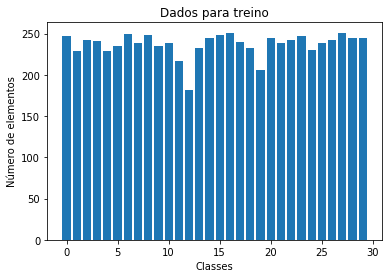

In [47]:
plt.bar(range(0,num_de_classes), num_num)
plt.xlabel('Classes')
plt.ylabel('Número de elementos')
plt.title('Dados para treino')

In [48]:
def preProcessing(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img) #IGUALA A DISTRIBUIÇÃO DE LUZ
    img = img/255 #NORMALIZA OS DADOS PARA FACILITAR NO TREINO
    return img

def Filtro(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = cv2.GaussianBlur(img,(5,5),0)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    img/255
    return img

In [49]:
X_train = np.array(list(map(Filtro,X_train)))
X_test = np.array(list(map(Filtro,X_test)))

In [50]:
X_train.shape

(7109, 28, 28)

In [51]:
X_test.shape

(1778, 28, 28)

In [52]:
X_train = X_train.reshape(7109,28,28,1)
X_test = X_test.reshape(1778,28,28,1)

In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [54]:
image_gen = ImageDataGenerator(rotation_range = 10,
                              width_shift_range = 0.1,
                              height_shift_range = 0.1,
                              shear_range = 0.1,
                              zoom_range = 0.2)

In [55]:
from tensorflow.keras.utils import to_categorical

In [56]:
y_cat_train = to_categorical(y_train, 30)
y_cat_test = to_categorical(y_test, 30)


In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, MaxPooling2D, MaxPool2D, Conv2D, Flatten

In [58]:
num_filtros = 60
tam_filtro1 = (5,5)
tam_filtro2 = (3,3)
tam_pool = (2,2)
nos = 500

In [59]:
from tensorflow.keras.optimizers import Adam
model =Sequential()

model.add(Conv2D(num_filtros, tam_filtro1, input_shape = (28,28,1), activation = 'relu'))
model.add(Conv2D(num_filtros, tam_filtro1, activation = 'relu'))
model.add(MaxPool2D(pool_size =tam_pool))

model.add(Conv2D(num_filtros//2, tam_filtro2, activation = 'relu'))
model.add(Conv2D(num_filtros//2, tam_filtro2, activation = 'relu'))
model.add(MaxPool2D(pool_size = tam_pool))

model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(nos,activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(30, activation = 'softmax'))

model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 60)        1560      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 20, 60)        90060     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 60)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 30)          16230     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 30)          8130      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 30)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 30)         

In [61]:
from tensorflow.keras.callbacks import EarlyStopping

In [62]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

In [63]:
image_gen.fit(X_train)

In [64]:
batch_size = 32
epochs = 50
steps_per_epoch = 1500

In [65]:
model.fit_generator(image_gen.flow(X_train,y_cat_train,batch_size=batch_size),
                                                epochs=epochs,
                                                steps_per_epoch=steps_per_epoch,
                                                validation_data=(X_test,y_cat_test),
                                                shuffle=1, callbacks = [early_stop])

Epoch 1/50
1500/1500 [==============================] - 244s 163ms/step - loss: 2.9580 - acc: 0.1651 - val_loss: 0.8919 - val_acc: 0.7559
Epoch 2/50
1500/1500 [==============================] - 149s 99ms/step - loss: 1.1208 - acc: 0.6639 - val_loss: 0.3553 - val_acc: 0.8988
Epoch 3/50
1500/1500 [==============================] - 150s 100ms/step - loss: 0.7295 - acc: 0.7809 - val_loss: 0.2422 - val_acc: 0.9398
Epoch 4/50
1500/1500 [==============================] - 214s 142ms/step - loss: 0.5991 - acc: 0.8221 - val_loss: 0.2333 - val_acc: 0.9325
Epoch 5/50
1500/1500 [==============================] - 148s 99ms/step - loss: 0.5325 - acc: 0.8419 - val_loss: 0.2261 - val_acc: 0.9421
Epoch 6/50
1500/1500 [==============================] - 169s 113ms/step - loss: 0.5017 - acc: 0.8491 - val_loss: 0.1809 - val_acc: 0.9471
Epoch 7/50
1500/1500 [==============================] - 246s 164ms/step - loss: 0.4682 - acc: 0.8594 - val_loss: 0.1756 - val_acc: 0.9505
Epoch 8/50
1500/1500 [==============

In [66]:
metrics = pd.DataFrame(model.history.history)

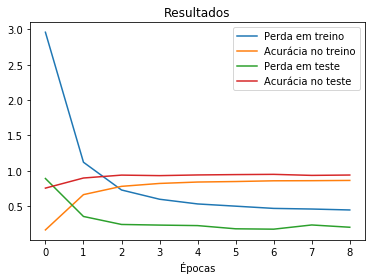

In [91]:
ax = metrics.plot(title = 'Resultados')
ax.set_xlabel('Épocas')
ax.legend(['Perda em treino', 'Acurácia no treino', 'Perda em teste', 'Acurácia no teste'])

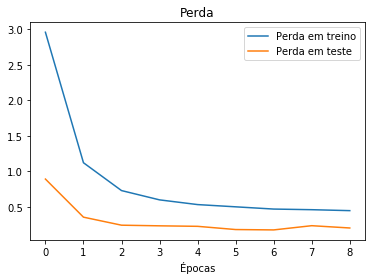

In [95]:
loss = metrics[['loss','val_loss']].plot(title = 'Perda')
loss.set_xlabel('Épocas')
loss.legend(['Perda em treino', 'Perda em teste'])

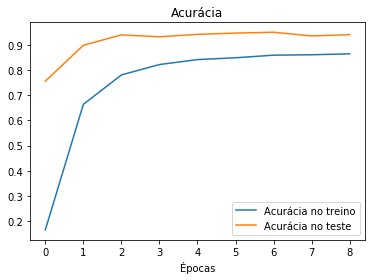

In [97]:
acc = metrics[['acc','val_acc']].plot(title = 'Acurácia')
acc.set_xlabel('Épocas')
acc.legend(['Acurácia no treino', 'Acurácia no teste'])

In [70]:
from sklearn.metrics import classification_report

In [71]:
pred = model.predict_classes(X_test)

In [72]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95        53
           1       0.93      0.93      0.93        71
           2       0.93      0.98      0.96        58
           3       1.00      0.98      0.99        59
           4       1.00      0.94      0.97        71
           5       1.00      0.92      0.96        65
           6       0.92      0.94      0.93        50
           7       1.00      0.90      0.95        62
           8       0.84      1.00      0.91        52
           9       0.98      0.98      0.98        65
          10       0.82      0.90      0.86        62
          11       0.98      0.95      0.97        66
          12       0.98      0.75      0.85        59
          13       0.94      0.97      0.96        67
          14       0.96      0.93      0.95        56
          15       0.91      0.98      0.94        52
          16       0.98      0.96      0.97        49
          17       1.00    

In [73]:
#Salva o modelo
#model.save('NovoModeloTreinado.h5')